In [1]:
!pip install qiskit --quiet
!pip install qiskit-aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 70.1 MB/s eta 0:00:00


In [44]:
# Deutsch Algorithm using Qiskit 2.x
# Compatible with Qiskit 2.0+ (2024–2025)

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# Choose the function type: 'constant_0', 'constant_1', 'balanced_0', 'balanced_1'
function_type = 'constant_0'

def deutsch_oracle(qc, function_type):
    """Implements oracle Uf for given function type."""
    if function_type == 'constant_0':
        # f(x)=0 → Do nothing
        pass
    elif function_type == 'constant_1':
        # f(x)=1 → Apply X on the output qubit
        qc.x(1)
    elif function_type == 'balanced_0':
        # f(x)=x → Apply CNOT (control: input, target: output)
        qc.cx(0, 1)
    elif function_type == 'balanced_1':
        # f(x)=NOT(x) → Apply X, then CNOT, then X
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)

In [45]:
# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc.barrier()
deutsch_oracle(qc, function_type)

In [46]:
# Step 4: Apply Hadamard to input qubit
qc.barrier()
qc.h(0)

# Step 5: Measure the first qubit
qc.measure(0, 0)

# Visualize circuit
print(qc.draw(output="text"))

           ░ ┌───┐ ░  ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░──░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░  ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░──░───────╫─
     └───┘ ░ └───┘ ░  ░       ║ 
c: 1/═════════════════════════╩═
                              0 


In [47]:
# Step 6: Simulate
sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print("\nMeasurement results:", counts)

# Interpret result
if list(counts.keys())[0] == '0':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


Measurement results: {'0': 1024}
→ Function is CONSTANT.


Task 1: Custom Oracle Design

In [16]:

def oracle_xor1(qc):
    qc.x(0)      # x -> x⊕1  (flip input)
    qc.cx(0, 1)  # controlled-NOT from input to output
    qc.x(0)      # restore input



In [17]:
# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc.barrier()
oracle_xor1(qc)

In [18]:
# Step 4: Apply Hadamard to input qubit
qc.barrier()
qc.h(0)

# Step 5: Measure the first qubit
qc.measure(0, 0)

# Visualize circuit
print(qc.draw(output="text"))

           ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░ └───┘┌─┴─┐└───┘ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░───────╫─
     └───┘ ░ └───┘ ░      └───┘      ░       ║ 
c: 1/════════════════════════════════════════╩═
                                             0 


In [23]:
# Step 6: Simulate
sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print("\nMeasurement results:", counts)

# Interpret result
if list(counts.keys())[0] == '0':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


# The result is always balanced, because x xor with 1 will always gives x  (so simply oracle(x) = x) [so balanced]


Measurement results: {'1': 1024}
→ Function is BALANCED.


Task 2: Bloch Sphere Visualization

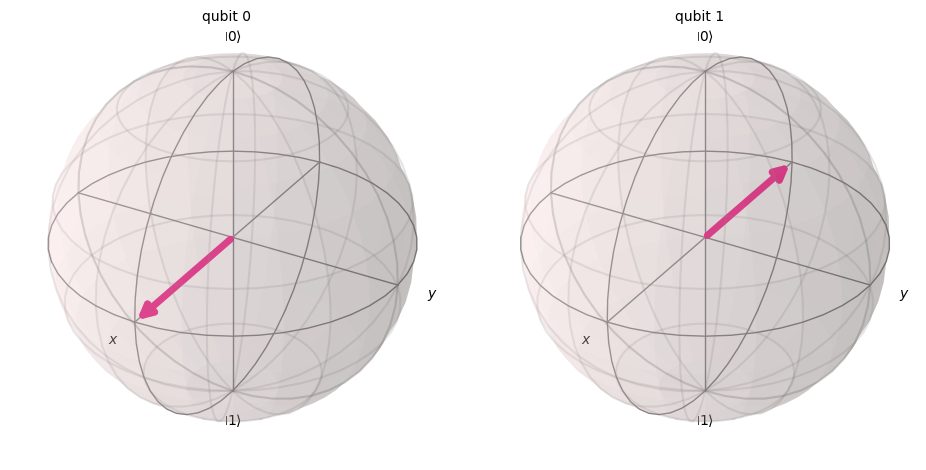

In [25]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector



# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

# Step 3: Apply the oracle
qc.barrier()
deutsch_oracle(qc, function_type)

state_after_oracle = Statevector.from_instruction(qc)
plot_bloch_multivector(state_after_oracle)

Task 3: Deutsch–Jozsa Extension

In [32]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer import AerSimulator # Import AerSimulator from qiskit_aer

In [37]:
qc = QuantumCircuit(3, 2)

qc.x(2)               # flip output qubit to |1>
qc.h(2)
qc.h([0, 1])
      # Hadamard on both input qubits and output qubit

# Bloch Sphere after Hadamard
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state).show()

In [38]:
# Step 2: Define oracle f(x1, x2) = x1 XOR x2
# Implementation: Apply CNOT from qubit 0 to output, then CNOT from qubit 1 to output
qc.cx(0, 2)
qc.cx(1, 2)

# Bloch Sphere after Oracle
state_after_oracle = Statevector.from_instruction(qc)
plot_bloch_multivector(state_after_oracle).show()

In [39]:
# Step 3: Apply Hadamard to input qubits again (not to output)
qc.h([0, 1])

# Step 4: Measure input qubits to classical bits 0 and 1
qc.measure([0, 1], [0, 1])

In [40]:
# Step 5: Simulate the circuit
simulator = AerSimulator() # Use AerSimulator() instead of Aer.get_backend()
result = simulator.run(qc).result() # Use simulator.run() instead of execute()
counts = result.get_counts()

# Output measurement results
print("Measurement results:", counts)

Measurement results: {'11': 1024}


In [41]:
if '00' in counts and counts['00'] == max(counts.values()):
    print("Function is constant")
else:
    print("Function is balanced")


Function is balanced


Task 4: Noise Impact

In [53]:
!pip install qiskit qiskit-aer --quiet

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error


# Create a sample circuit - Deutsch oracle
qc = QuantumCircuit(2, 1)
qc.h(0)
qc.h(1)
qc.cx(0, 1)
qc.h(0)
qc.measure(0, 0)

# Build a noise model with depolarizing errors
noise_model = NoiseModel()
error_1q = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3'])
error_2q = depolarizing_error(0.1, 2)
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

# AerSimulator with noise
sim = AerSimulator(noise_model=noise_model)

compiled_circ = transpile(qc, sim)
result = sim.run(compiled_circ, shots=1024).result()
counts = result.get_counts()
print(counts)

# due to the noise, the results vary significantly

{'1': 121, '0': 903}


Task 5: Compare Classical vs Quantum Queries

In [55]:
def classical_oracle(x):
    # Example f(x) = x XOR 1 (balanced)
    return x ^ 1

def classical_query_counter():
    queried_results = []
    queries_made = 0

    # For n=1 bit input, inputs = [0, 1]
    inputs = [0, 1]
    for x in inputs:
        queries_made += 1
        y = classical_oracle(x)
        queried_results.append(y)
        # Check if all queried_outputs are same so far (constant)
        if len(set(queried_results)) > 1:
            # Not constant - balanced function detected
            return queries_made, "Balanced"
    # If all queried are same
    return queries_made, "Constant"

queries, function_type = classical_query_counter()
print(f"Classical queries needed: {queries}, Detected: {function_type}")

# As expected, in classical, we need 2 queries, but in quantum, just 1 query is enough

Classical queries needed: 2, Detected: Balanced
